# Goal : Predict Survivors on Titanic Crew

# 1.0 Introduction
1.1 Business Understanding / Project Objective

The sinking of the Titanic is one of the most infamous shipwrecks in history.
On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).



## 1.2 Data Understanding Description of Variables

PassengerId = Passenger Id 
Survived = 0 (No) 1 (Yes) 
Pclass = Passenger Class ( 1=1st; 2=2nd; 3=3rd) 
Age = Age(years) 
Name = Name S
ex = 0 (male) 1 (female) 
SibSp =Number of siblings / spouses aboard
Parch = Number of parents/ children aboard 
Ticket = Ticket Number 
Fare = Passenger Fare(British Pound)
Cabin = Cabin Embarked = Boarding location (S= Southhampton; C= Cherbourg; Q= Queenstown)

In [5]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#Feature Engineering
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2  # Univariate Selection using KBest
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import compose
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
#Models
import xgboost as xgb 
from sklearn import tree
from sklearn.svm import SVC
from sklearn import linear_model


#Model Evaluation
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score, fbeta_score
from sklearn import metrics
from sklearn.utils import all_estimators


# Cross Validation and Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import  RandomizedSearchCV

#Others
import pickle, os


## Load and Explore Datasets

In [6]:
#load train data
train_data =pd.read_csv('C:/Users/HP/Downloads/Kaggle Datasets/train.csv')

#load train data
test_data =pd.read_csv('C:/Users/HP/Downloads/Kaggle Datasets/test.csv')

#merged dataset
merged_data =[train_data, test_data]

#load kaggle sample submission data
sample_sub =pd.read_csv('C:/Users/HP/Downloads/Kaggle Datasets/gender_submission.csv')



In [7]:
# defining the target column
target_cols =list(set(train_data.columns)- set(test_data.columns))
target_col = target_cols[-1]
features =test_data.columns
target_cols, target_col

(['Survived'], 'Survived')

In [8]:
#viewing train dataset
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [10]:
train_data.shape, test_data.shape

((891, 12), (418, 11))

In [11]:
# checking unique values in each column
train_data.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [12]:
# checking unique values in each column
test_data.nunique()

PassengerId    418
Pclass           3
Name           418
Sex              2
Age             79
SibSp            7
Parch            8
Ticket         363
Fare           169
Cabin           76
Embarked         3
dtype: int64

# Check missing values and Initial cleaning

In [13]:
#view general data info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [14]:
# dropping useless columns
train_data =train_data.drop(columns = ['Cabin','Ticket','Name'], axis =1)
train_data 

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,NaN,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


In [15]:
#view general data info
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [16]:
# dropping useless columns
test_data =test_data.drop(columns = ['Cabin','Ticket','Name'], axis =1)
test_data 

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...,...
413,1305,3,male,NaN,0,0,8.0500,S
414,1306,1,female,39.0,0,0,108.9000,C
415,1307,3,male,38.5,0,0,7.2500,S
416,1308,3,male,NaN,0,0,8.0500,S


In [17]:
# for percent [0; 100] of nan in test dataframe
features = test_data.columns
missing_threshold = 50
check = (test_data[features].isna().sum() / ((test_data.shape[0]) / 100))

valid_features = check[check < missing_threshold].index.to_list()
check.sort_values(ascending=False)

Age            20.574163
Fare            0.239234
PassengerId     0.000000
Pclass          0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Embarked        0.000000
dtype: float64

In [18]:
#dealing with missing values in Age column
# First Deal with missing values in age column  by imputing with median
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(test_data[['Age']])
test_data['Age'] = imputer.transform(test_data[['Age']])

In [19]:
#dealing with missing values in Fare column
#Using forward fill to fill the nulls, and then filling any missing ones with backfill
test_data = test_data.ffill().bfill()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         418 non-null    float64
 7   Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


In [20]:
# for percent [0; 100] of nan in train dataframe
features = train_data.columns
missing_threshold = 50
check = (train_data[features].isna().sum() / ((train_data.shape[0]) / 100))

valid_features = check[check < missing_threshold].index.to_list()
check.sort_values(ascending=False)

Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Fare            0.000000
dtype: float64

In [21]:
#dealing with missing values in Age column
# First Deal with missing values in age column  by imputing with median
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(train_data[['Age']])
train_data['Age'] = imputer.transform(train_data[['Age']])

In [22]:
#dealing with missing values in Embarked column
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0],inplace = True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


In [23]:
#check shape after cleaning
train_data.shape, test_data.shape

((891, 9), (418, 8))

## Feature Engineering , Normalization

In [24]:
train_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,13.0000,S
887,888,1,1,female,19.0,0,0,30.0000,S
888,889,0,3,female,28.0,1,2,23.4500,S
889,890,1,1,male,26.0,0,0,30.0000,C


## Split your train dataset

In [25]:
target =train_data['Survived']

In [26]:
useless_features = ['PassengerId','Survived']
useful_features = list(set(valid_features) - set(useless_features))
print(f"[Info] '{len(useful_features)}' feature(s) to use for the next steps. ")

[Info] '7' feature(s) to use for the next steps. 


In [27]:
num_cols = train_data[useful_features].select_dtypes(include=np.number).columns.tolist()
cat_cols = train_data[useful_features].select_dtypes(exclude=np.number).columns.tolist()

print( f"Numeric features : {len(num_cols)}" )
print( f"Categorical features : {len(cat_cols)}" )

Numeric features : 5
Categorical features : 2


# Split your train dataset

In [28]:

X = train_data[useful_features]
y = target

X_test = test_data[useful_features]

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=0)
(X_train.shape, y_train.shape) , (X_eval.shape, y_eval.shape), (X_test.shape)

(((712, 7), (712,)), ((179, 7), (179,)), (418, 7))

## Normalize and Encode the dataset

In [29]:
# Pipeline for the Numeric features 
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", MinMaxScaler())]
)

# Pipeline for the Categorical features
encoder_categories = [train_data[cat_cols[i] ].append(test_data[cat_cols[i] ] ).dropna().unique() for i in range(len(cat_cols)) ]

cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", preprocessing.OneHotEncoder(categories=encoder_categories, drop="first", sparse=False)) #if_binary
           ])

# Associate the two pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, selector(dtype_include="number")),
        ("cat", cat_transformer, selector(dtype_exclude="number")),
        # ("num", num_transformer, num_cols),
        # ("cat", cat_transformer, cat_cols),
    ]
)
X_train__, X_eval__, X_test__ = preprocessor.fit_transform(X_train), preprocessor.transform(X_eval), preprocessor.transform(X_test)

# New categorical feature names
feature_names_out = preprocessor.named_transformers_['cat'][-1].get_feature_names_out().tolist()
indexes = [ int(feature_names_out[i][1:feature_names_out[i].find("_")]) for i in range(len(feature_names_out))]
cat_cols_encoded = [  col.replace( f"x{i}", cat_cols[i] )  for col,i in zip(feature_names_out, indexes)]
print( f"Categorical features after encoding : {len(cat_cols_encoded)}" )

# train df
df_X_train = pd.DataFrame(X_train__, columns=num_cols+cat_cols_encoded)

# eval df
df_X_eval = pd.DataFrame(X_eval__, columns=num_cols+cat_cols_encoded)

# test df
df_X_test = pd.DataFrame(X_test__, columns=num_cols+cat_cols_encoded)

Categorical features after encoding : 3


In [30]:
pd.set_option('display.max_columns', None)
df_X_train.head()

,Age,Parch,Pclass,SibSp,Fare,Sex_female,Embarked_C,Embarked_Q
0,0.344510,0.333333,1.0,0.000,0.029758,1.0,1.0,0.0
1,0.382327,0.000000,0.5,0.000,0.020495,0.0,0.0,0.0
2,0.382327,0.166667,0.5,0.125,0.072227,0.0,1.0,0.0
3,0.243666,0.000000,1.0,0.000,0.007832,0.0,1.0,0.0
4,0.256271,0.000000,1.0,0.000,0.014151,0.0,0.0,0.0


In [31]:
df_X_eval.head()

,Age,Parch,Pclass,SibSp,Fare,Sex_female,Embarked_C,Embarked_Q
0,0.344510,0.000000,1.0,0.000,0.028221,0.0,1.0,0.0
1,0.344510,0.000000,1.0,0.000,0.014737,0.0,0.0,0.0
2,0.079793,0.166667,1.0,0.500,0.056848,0.0,0.0,1.0
3,0.344510,0.000000,0.0,0.125,0.285990,1.0,1.0,0.0
4,0.357116,0.333333,1.0,0.000,0.029758,1.0,1.0,0.0


In [32]:
df_X_test.head()

,Age,Parch,Pclass,SibSp,Fare,Sex_female,Embarked_C,Embarked_Q
0,0.426446,0.000000,1.0,0.000,0.015282,0.0,0.0,1.0
1,0.584016,0.000000,1.0,0.125,0.013663,1.0,0.0,0.0
2,0.773100,0.000000,0.5,0.000,0.018909,0.0,0.0,1.0
3,0.331905,0.000000,1.0,0.000,0.016908,0.0,0.0,0.0
4,0.268877,0.166667,1.0,0.125,0.023984,1.0,0.0,0.0


# Training Multiple Models using Pipeline and Making Comparison

In [33]:
estimator_type = 'classifier' # {"classifier", "regressor", "cluster",}    
estimators = all_estimators(type_filter=estimator_type)
random_state = 0

all_models = []
for name, EstimatorClass in estimators:
    try:
        if "CV" in name or "IC" in name or "Isotonic" in name or "Elastic" in name: continue
        if 'random_state' in EstimatorClass().get_params().keys():
            model = EstimatorClass(random_state=random_state)
        else:
            model = EstimatorClass()

        all_models.append(model)
        # print('Appending', name)
    except Exception as e:
        pass
        # print('Unable to import', name)
        # print(e)

print(f"[Info] Estimators of type '{estimator_type}' loaded: {len(all_models)}" )

[Info] Estimators of type 'classifier' loaded: 31


In [34]:
# preprocessor for the raw features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, selector(dtype_include="number")),
        ("cat", cat_transformer, selector(dtype_exclude="number")),
        # ("num", num_transformer, num_cols),
        # ("cat", cat_transformer, cat_cols),
    ]
)

# end 2 end pipeline
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("estimator", None)]
    )
# Grid search parameters
param_grid_ = {
    'estimator': all_models[:5], 
}

# SearchCV
end2end_grid_search = GridSearchCV(pipe, param_grid_, cv=3, scoring="neg_mean_absolute_error", refit=True, n_jobs=-1)

In [35]:

end2end_grid_search = end2end_grid_search.fit(X, y)

In [36]:

end2end_grid_search.best_params_


{'estimator': AdaBoostClassifier(random_state=0)}

In [37]:
cv_results = end2end_grid_search.cv_results_

# pick out the best results
# =========================
scores_df = pd.DataFrame(cv_results)
scores_df_sorted = scores_df.sort_values(by='rank_test_score')
scores_df_sorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.406723,0.165968,0.027617,0.003868,AdaBoostClassifier(random_state=0),{'estimator': AdaBoostClassifier(random_state=0)},-0.249158,-0.185185,-0.168350,-0.200898,0.034810,1
1,0.087539,0.013171,0.009874,0.007013,BaggingClassifier(random_state=0),{'estimator': BaggingClassifier(random_state=0)},-0.228956,-0.181818,-0.218855,-0.209877,0.020264,2
2,0.477318,0.300567,0.022334,0.006798,BernoulliNB(),{'estimator': BernoulliNB()},-0.276094,-0.202020,-0.222222,-0.233446,0.031265,3
4,0.056400,0.028723,0.014854,0.000870,ComplementNB(),{'estimator': ComplementNB()},-0.299663,-0.225589,-0.198653,-0.241302,0.042708,4
3,0.066678,0.005446,0.069254,0.074606,CategoricalNB(),{'estimator': CategoricalNB()},-0.289562,-0.212121,NaN,NaN,NaN,5


### Apply the optimized model on the Eval dataset

In [38]:
#Predicting the response for test dataset
eval_pred = end2end_grid_search.predict(X_eval)
     

#evaluate results
acc = accuracy_score(y_eval,eval_pred)
prec = precision_score(y_eval,eval_pred)
rec = recall_score(y_eval, eval_pred)
f1 = f1_score(y_eval,eval_pred)
f2 = fbeta_score(y_eval,eval_pred,beta=2.0)

Model_results = pd.DataFrame([['AdaBoost',acc,prec,rec,f1,f2]],columns=['Model', 'Accuracy','Precision','Recall','F1 score','F2 score'])
Model_results

,Model,Accuracy,Precision,Recall,F1 score,F2 score
0,AdaBoost,0.843575,0.80597,0.782609,0.794118,0.787172


### Apply the optimized model on the test dataset provided by Kaggle

In [39]:

test_pred = end2end_grid_search.predict(X_test)

#### Get the same prediction format as the sample_submission file

In [40]:
sample_sub =pd.read_csv('C:/Users/HP/Downloads/Kaggle Datasets/gender_submission.csv')
sample_sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


<AxesSubplot:>

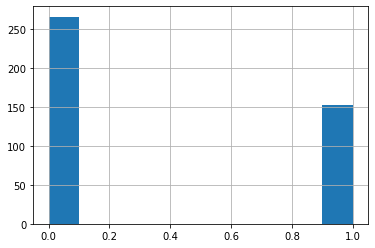

In [41]:

sample_sub.Survived.hist()

<AxesSubplot:>

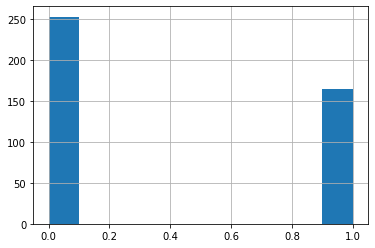

In [42]:
sample_sub['Survived'] = test_pred
sample_sub.Survived.hist()


### Processing Prediction for Kaggle site

In [43]:

sample_sub.to_csv("kaggle_sub.csv", index=False)

#### Exporting ML components for API

In [44]:

ml = {'pipeline':end2end_grid_search.best_estimator_,
      'numeric_columns': num_cols,
      'categorical_columns': cat_cols,}

#### Loading After Exportation

In [45]:
with open("ml_pipeline.pkl", 'wb') as file:
    pickle.dump(ml, file)
     

In [48]:
with open('ml_pipeline.pkl', 'rb') as file:
    loaded_object = pickle.load(file)

In [49]:
 loaded_object

{'pipeline': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('scaler',
                                                                    MinMaxScaler())]),
                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x00000150F4BCAEB0>),
                                                  ('cat',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('encoder',
                                                                    OneHotEncoder(